# Customer Churn

## Assume those who had transaction between 2020/01/01- 2020/03/31, but did NOT have  transaction after 2020/03/31, churned. Could you predict that?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import date, time, datetime

In [2]:
cut_day='2020-03-31'
cut_day

day1='2020-01-01'

In [3]:
trans_df = pd.read_csv('../data/trans.csv')
user_df = pd.read_csv('../data/users.csv')

#trans_df=trans_df.loc[trans_df.trans_state=='COMPLETED']
trans_df['record_date'] = pd.to_datetime(trans_df['record_date'], utc=True)
user_df['record_date'] = pd.to_datetime(user_df['record_date'], utc=True)
last_day=trans_df['record_date'].max()
user_df['user_days']=(last_day-user_df['record_date']).dt.days
user_df=user_df.set_index(['user_id']).sort_values('record_date', ascending=True)



trans_hist=trans_df.loc[trans_df.record_date<day1,:]
trans_active=trans_df.loc[(trans_df.record_date<=cut_day)&(trans_df.record_date>=day1),:]
trans_NoChurn=trans_df.loc[(trans_df.record_date>cut_day)&(trans_df.user_id.isin(trans_active.user_id)),:]
churn_rate=(len(trans_active.user_id.unique())-len(trans_NoChurn.user_id.unique()))*100/len(trans_active.user_id.unique())
print('Number of current users before 2020-01-01 is {}'.format(len(trans_hist.user_id.unique())))
print('Number of current active users 2020-01-01 to 2020-03-31 is {}'.format(len(trans_active.user_id.unique())))
print('Number of active users after 2020-03-31 is {}'.format(len(trans_NoChurn.user_id.unique())))
print('Customer churn rate after 2020-03-31 is {:.2f}%'.format(churn_rate))


trans_hist=trans_hist.set_index(['user_id']).sort_values('record_date', ascending=True)
trans_hist['record_date'] = pd.to_datetime(trans_hist['record_date'], utc=True)


trans_hist['next_trans'] = trans_hist['record_date'].groupby("user_id").shift(-1)
trans_hist['day_diff']=(trans_hist['next_trans']-trans_hist['record_date']).dt.days
trans_hist=trans_hist.drop('next_trans', axis=1)


trans_active=trans_active.set_index(['user_id']).sort_values('record_date', ascending=True)
trans_active['record_date'] = pd.to_datetime(trans_active['record_date'], utc=True)

trans_active['next_trans'] = trans_active['record_date'].groupby("user_id").shift(-1)
trans_active['day_diff']=(trans_active['next_trans']-trans_active['record_date']).dt.days
trans_active=trans_active.drop('next_trans', axis=1)
trans_active['last_trans_day'] =(trans_active.record_date.max()- trans_active.groupby('user_id')['record_date'].transform('max')).dt.days


trans_hist_monthly = trans_hist.groupby(['user_id', trans_hist['record_date'].dt.year,
                                   trans_hist['record_date'].dt.month]).\
       agg({'trans_id':'count', 'trans_amount':['mean'], 'day_diff':['mean']}).fillna(0)

trans_hist_monthly.columns=['count','trans_amount','day_diff']

trans_active_montthly = trans_active.groupby(['user_id', trans_active['record_date'].dt.year,
                                   trans_active['record_date'].dt.month]).\
       agg({'trans_id':'count', 'trans_amount':['mean'], 'day_diff':['mean'], 'last_trans_day':['max']}).fillna(0)

trans_active_montthly.columns=['count','trans_amount','day_diff', 'last_trans_day']


trans_hist_user=trans_hist_monthly.groupby('user_id').\
                    agg({'count':['mean'], 'trans_amount':['mean'], 'day_diff':['mean']})
trans_hist_user.columns=['count', 'trans_amount', 'day_diff']


trans_active_user=trans_active_montthly.groupby('user_id').\
                    agg({'count':['mean'], 'trans_amount':['mean'], 'day_diff':['mean'], 'last_trans_day':['max']})
trans_active_user.columns=['count', 'trans_amount', 'day_diff', 'last_trans_day']

Number of current users before 2020-01-01 is 9372
Number of current active users 2020-01-01 to 2020-03-31 is 6685
Number of active users after 2020-03-31 is 5132
Customer churn rate after 2020-03-31 is 23.23%


In [4]:
trans_user=pd.merge(trans_hist_user,trans_active_user, how='right', on='user_id', suffixes=('_before','_now')).fillna(0)

In [5]:
trans_user=pd.merge(trans_user,user_df[['user_days']], how='left', on='user_id', suffixes=('','')).fillna(0)

In [6]:
trans_user

,count_before,trans_amount_before,day_diff_before,count_now,trans_amount_now,day_diff_now,last_trans_day,user_days
user_id,,,,,,,,
user_0,16.250000,36.641226,2.661244,13.666667,25.539828,1.428042,1,487
user_1,8.111111,50.640900,4.630866,4.000000,95.687500,10.100000,35,471
user_10,21.250000,51.293883,1.226983,22.000000,37.997273,1.150219,3,496
user_100,5.111111,168.960776,13.064815,9.333333,121.732222,1.925926,10,485
user_1002,4.800000,223.950238,9.563095,14.666667,141.985667,1.083333,16,487
...,...,...,...,...,...,...,...,...
user_9770,0.000000,0.000000,0.000000,1.000000,0.850000,0.000000,2,285
user_9788,0.000000,0.000000,0.000000,41.666667,49.870997,0.601829,1,282
user_9926,0.000000,0.000000,0.000000,2.000000,122.760000,0.000000,83,278


In [7]:
trans_user.describe()

,count_before,trans_amount_before,day_diff_before,count_now,trans_amount_now,day_diff_now,last_trans_day,user_days
count,6686.000000,6.686000e+03,6686.000000,6686.000000,6.686000e+03,6686.000000,6686.000000,6686.000000
mean,12.923735,1.161719e+05,10.419469,14.689251,1.606347e+05,4.449907,16.218068,382.090787
std,16.379109,8.452236e+06,13.559621,23.375344,1.225485e+07,5.853142,21.502549,61.810130
min,0.000000,0.000000e+00,0.000000,1.000000,0.000000e+00,0.000000,0.000000,254.000000
25%,4.000000,1.520825e+01,2.597265,3.000000,1.256783e+01,0.604930,1.000000,329.000000
50%,7.800000,3.177511e+01,6.451124,7.000000,2.763036e+01,2.286681,6.000000,379.000000
75%,15.714286,6.764828e+01,13.000000,16.000000,6.730100e+01,5.833333,24.000000,433.000000
max,245.250000,6.899640e+08,161.000000,258.666667,1.000000e+09,43.000000,89.000000,498.000000


In [ ]:
# trans_user['count_growth']=(trans_user['count']-trans_user['count_past'])/(trans_user['count_past']+1)
# trans_user['amount_growth']=(trans_user['trans_amount']-trans_user['trans_amount_past'])/(trans_user['trans_amount_past']+1)
# trans_user['day_growth']=(trans_user['day_diff']-trans_user['day_diff_past'])/(trans_user['day_diff_past']+1)

In [8]:
trans_user['churn']=1
trans_user.loc[trans_user.index.isin(trans_NoChurn.user_id),'churn']=0

In [9]:
trans_user.describe()

,count_before,trans_amount_before,day_diff_before,count_now,trans_amount_now,day_diff_now,last_trans_day,user_days,churn
count,6686.000000,6.686000e+03,6686.000000,6686.000000,6.686000e+03,6686.000000,6686.000000,6686.000000,6686.000000
mean,12.923735,1.161719e+05,10.419469,14.689251,1.606347e+05,4.449907,16.218068,382.090787,0.232276
std,16.379109,8.452236e+06,13.559621,23.375344,1.225485e+07,5.853142,21.502549,61.810130,0.422316
min,0.000000,0.000000e+00,0.000000,1.000000,0.000000e+00,0.000000,0.000000,254.000000,0.000000
25%,4.000000,1.520825e+01,2.597265,3.000000,1.256783e+01,0.604930,1.000000,329.000000,0.000000
50%,7.800000,3.177511e+01,6.451124,7.000000,2.763036e+01,2.286681,6.000000,379.000000,0.000000
75%,15.714286,6.764828e+01,13.000000,16.000000,6.730100e+01,5.833333,24.000000,433.000000,0.000000
max,245.250000,6.899640e+08,161.000000,258.666667,1.000000e+09,43.000000,89.000000,498.000000,1.000000


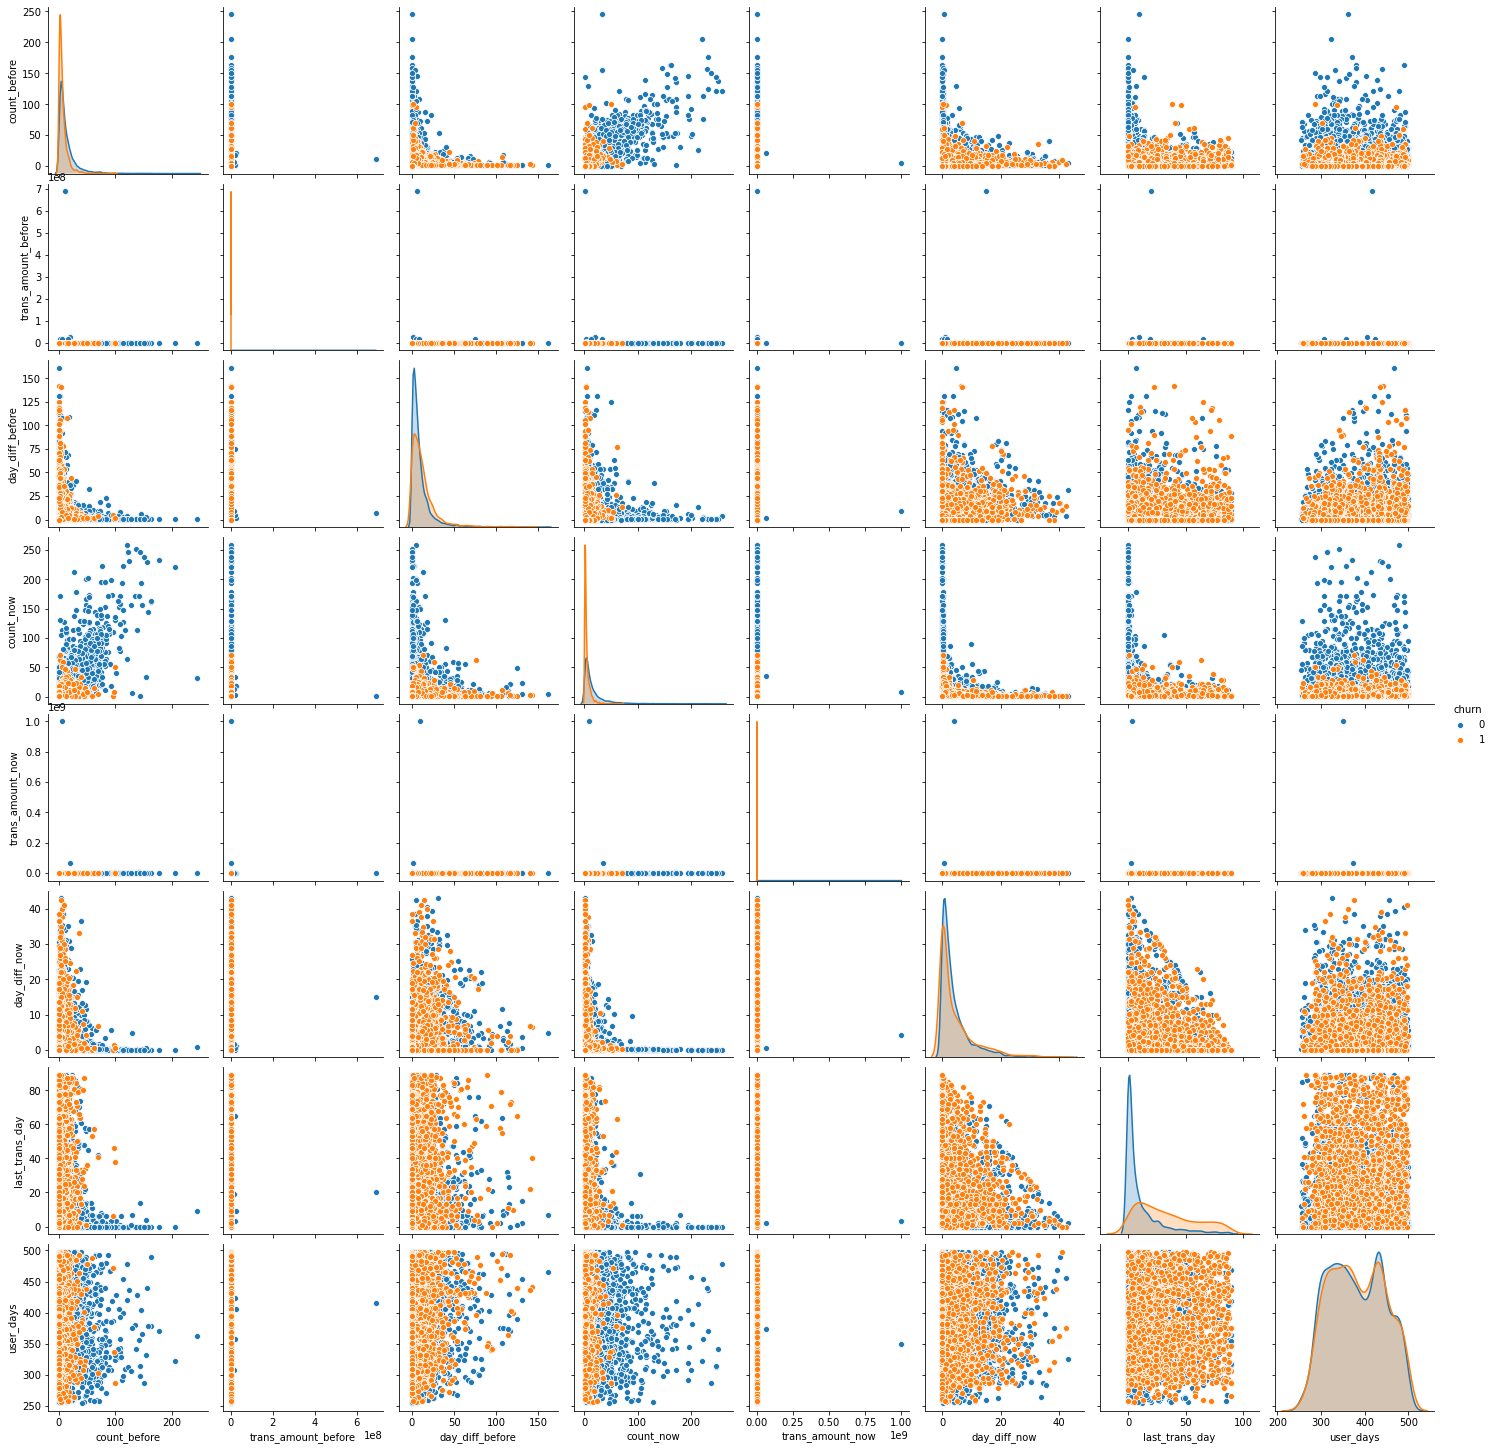

In [10]:
sns.pairplot(trans_user, hue='churn', diag_kind='kde');

In [11]:
NumCols=trans_user.columns.drop('churn')
NumCols

Index(['count_before', 'trans_amount_before', 'day_diff_before', 'count_now',
       'trans_amount_now', 'day_diff_now', 'last_trans_day', 'user_days'],
      dtype='object')

In [13]:
trans_user.to_csv('../data/churn.csv', index = True)

In [ ]:
# trans=trans_user.loc[(trans_user.trans_amount_past<10000)&(trans_user.count_past<200)\
#                                &(trans_user.trans_amount<10000),:]
# sns.pairplot(trans, hue='churn');

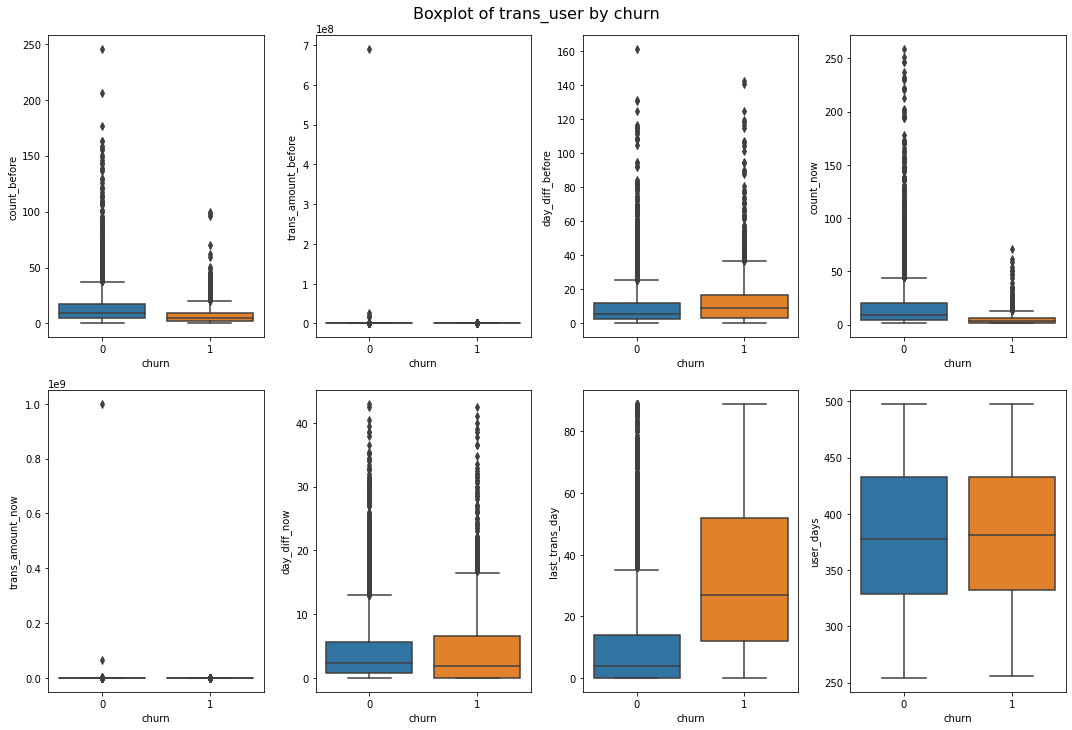

In [16]:
fig, ax=plt.subplots(nrows=2,ncols=4, figsize=(15,10))
fig.suptitle('Boxplot of trans_user by churn',y=1.01, fontsize=16)
for i, ax in enumerate(fig.axes):
    if i < len(NumCols):
        sns.boxplot(y=NumCols[i], x='churn', data=trans_user, ax=ax)
fig.tight_layout();

In [17]:
X=trans_user.drop('churn', axis=1)
y=trans_user['churn']

In [18]:
from sklearn.preprocessing import PowerTransformer

scaler=PowerTransformer()
X_scaled=scaler.fit_transform(X)

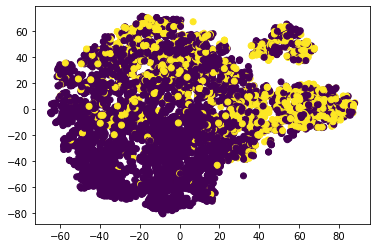

In [19]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init='random', random_state=0)
tsne_proj = tsne.fit_transform(X_scaled)

plt.scatter(tsne_proj[:, 0], tsne_proj[:, 1], c=y);

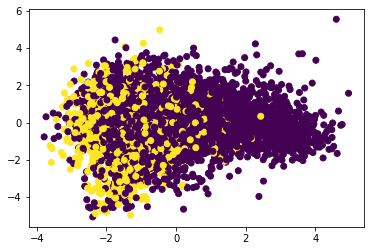

In [20]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_proj=pca.fit_transform(X_scaled)

plt.scatter(pca_proj[:, 0], pca_proj[:, 1], c=y);

In [21]:
from sklearn.neighbors import KNeighborsClassifier

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import BaggingClassifier

from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.svm import SVC

from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y,stratify=y, random_state=42)

print(X_train.shape, X_test.shape)
print(y_train.sum(), y_test.sum())

(5014, 8) (1672, 8)
1165 388


In [23]:
from sklearn.model_selection import GridSearchCV


knn_param_grid = {'n_neighbors': np.arange(1, 30),
                  'weights':['uniform','distance'],
                  'p': [1,2]}

knn_grid = GridSearchCV(KNeighborsClassifier(), 
                        knn_param_grid, cv=5, scoring = 'roc_auc', 
                        return_train_score=True)
knn_grid.fit(X_train, y_train)
print('Knn Best parameters', knn_grid.best_params_)
knn_model = knn_grid.best_estimator_
print('Knn best score = ',knn_grid.best_score_ )

Knn Best parameters {'n_neighbors': 29, 'p': 2, 'weights': 'uniform'}
Knn best score =  0.8134179102735892


In [24]:
dt_param_grid = {'max_depth': np.arange(2, 10)}

dt_grid = GridSearchCV(DecisionTreeClassifier(random_state=1), 
                       dt_param_grid, cv=5, scoring = 'roc_auc', 
                       return_train_score=True)

dt_grid.fit(X_train, y_train)
print('DecosionTree Best parameters', dt_grid.best_params_)
dt_model = dt_grid.best_estimator_
print('DecosionTree best score = ',dt_grid.best_score_ )

DecosionTree Best parameters {'max_depth': 4}
DecosionTree best score =  0.8118831607344085


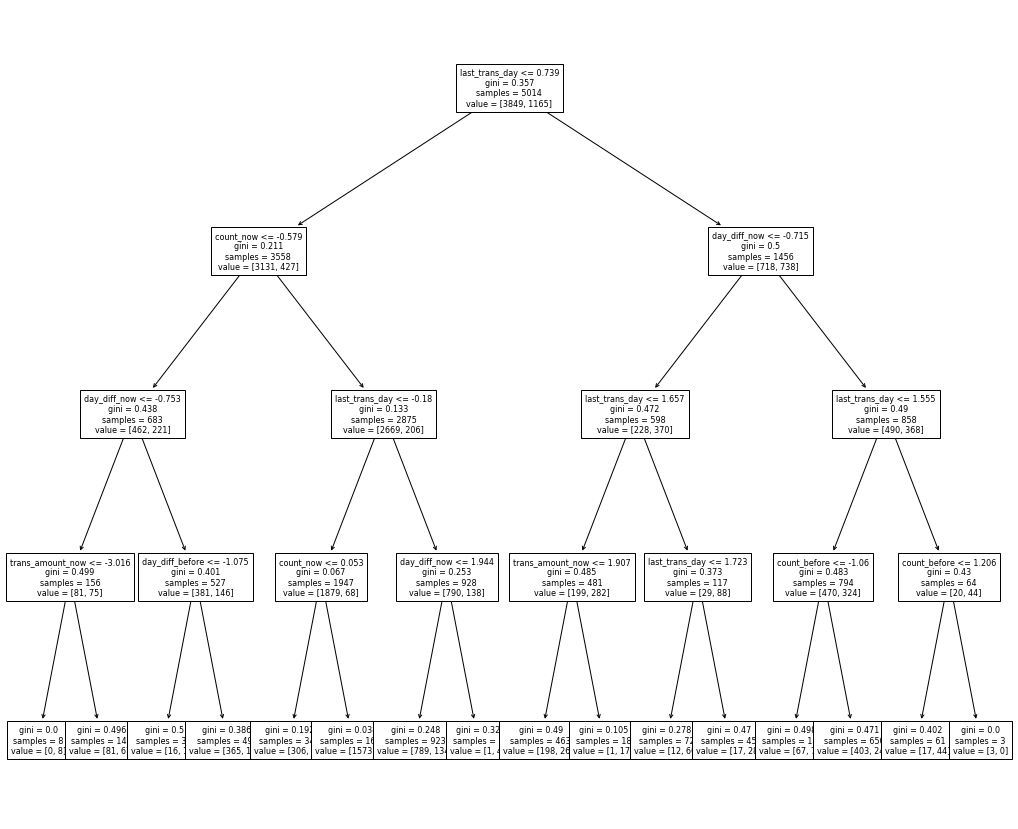

In [25]:
from sklearn import tree
plt.figure(figsize=(18,15))
tree.plot_tree(dt_model,feature_names=X.columns, fontsize=8);

In [26]:
rf_param_grid = {'n_estimators': [50, 100, 120, 150, 200],
                  'max_depth': np.arange(2, 10),
                  'min_samples_split': np.linspace(0.01,1,10)}

rf_grid = GridSearchCV(RandomForestClassifier(random_state=1), 
                       rf_param_grid, cv=5, scoring = 'roc_auc', 
                       return_train_score=True)
rf_grid.fit(X_train, y_train)
print('RandomForest Best parameters', rf_grid.best_params_)
rf_model = rf_grid.best_estimator_
print('RandomForest best score = ',rf_grid.best_score_ )

RandomForest Best parameters {'max_depth': 7, 'min_samples_split': 0.01, 'n_estimators': 200}
RandomForest best score =  0.8292613449270834


In [32]:
logr_param_grid = {'C': [0.1, 1, 10, 50, 100],
                  'penalty':['l1', 'l2']}

logr_grid = GridSearchCV(LogisticRegression(solver='liblinear'), 
                         logr_param_grid, cv=5, scoring = 'roc_auc',
                         return_train_score=True)
logr_grid.fit(X_train, y_train)
print('LogisticRegression Best parameters', logr_grid.best_params_)
logr_model = logr_grid.best_estimator_
print('LogisticRegression best score = ',logr_grid.best_score_ )

LogisticRegression Best parameters {'C': 0.1, 'penalty': 'l1'}
LogisticRegression best score =  0.8264378407218169


In [33]:
svc_param_grid = {'C': np.logspace(-2,2,10),'gamma':np.logspace(-2,2,10)}

svc_grid = GridSearchCV(SVC(kernel='rbf'), 
                        svc_param_grid, cv=5, scoring = 'roc_auc', 
                        return_train_score=True)
svc_grid.fit(X_train, y_train)
print('LogisticRegression Best parameters', svc_grid.best_params_)
svc_model = svc_grid.best_estimator_
print('LogisticRegression best score = ',svc_grid.best_score_ )

LogisticRegression Best parameters {'C': 12.915496650148826, 'gamma': 0.01}
LogisticRegression best score =  0.8144071729405784


In [34]:
from sklearn.model_selection import cross_val_score
nb_scored = cross_val_score(GaussianNB(), X_train, y_train, cv=5, scoring = 'roc_auc')

print('Naive Bayes mean scores = ',np.mean(nb_scored) )

Naive Bayes mean scores =  0.8108467408959102


In [35]:
from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [36]:
knn_model.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)
print('Knn best model confusion matrix on test data  \n',confusion_matrix(y_test, knn_pred)  )
print('*********************************************')
print('Knn best model Precision  on test data = {:.2f}'.format(precision_score(y_test, knn_pred)))
print('Knn best model Recall  on test data = {:.2f}'.format(recall_score(y_test, knn_pred)))
print('Knn best model F1 on test data = {:.2f}'.format(f1_score(y_test, knn_pred)))
print('Knn best model Accuracy  on test data = {:.2f}'.format(accuracy_score(y_test, knn_pred)))
print('*********************************************')

dt_model.fit(X_train, y_train)
dt_pred = dt_model.predict(X_test)
print('Decision Tree best model confusion matrix on test data  \n',confusion_matrix(y_test, dt_pred)  )
print('*********************************************')
print('Decision Tree best model Precision  on test data = {:.2f}'.format(precision_score(y_test, dt_pred)))
print('Decision Tree best model Recall on test data = {:.2f}'.format(recall_score(y_test, dt_pred)))
print('Decision Tree best model F1 on test data  = {:.2f}'.format(f1_score(y_test, dt_pred)))
print('Decision Tree best model Accuracy  on test data = {:.2f}'.format(accuracy_score(y_test, dt_pred)))
print('*********************************************')

rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
print('Random Forest best model confusion matrix on test data  \n',confusion_matrix(y_test, rf_pred)  )
print('*********************************************')
print('Random Forest best model Precision  on test data = {:.2f}'.format(precision_score(y_test, rf_pred)))
print('Random Forest best model Recall on test data = {:.2f}'.format(recall_score(y_test, rf_pred)))
print('Random Forest best model F1 on test data  = {:.2f}'.format(f1_score(y_test, rf_pred)))
print('Random Forest best model Accuracy  on test data = {:.2f}'.format(accuracy_score(y_test, rf_pred)))
print('*********************************************')

logr_model.fit(X_train, y_train) 
logr_pred= logr_model.predict(X_test)
print('Logistic Regression best model confusion matrix on test data  \n',confusion_matrix(y_test, logr_pred)  )
print('*********************************************')
print('Logistic Regression best model Precision  on test data = {:.2f}'.format(precision_score(y_test, logr_pred)))
print('Logistic Regression best model Recall on test data = {:.2f}'.format(recall_score(y_test, logr_pred)))
print('Logistic Regression best model F1 on test data  = {:.2f}'.format(f1_score(y_test, logr_pred)))
print('Logistic Regression best model Accuracy  on test data = {:.2f}'.format(accuracy_score(y_test, logr_pred)))
print('*********************************************')

svc_model.fit(X_train, y_train) 
svc_pred = svc_model.predict(X_test)
print('SVC best model confusion matrix on test data  \n',confusion_matrix(y_test, svc_pred)  )
print('*********************************************')
print('SVC best model Precision  on test data = {:.2f}'.format(precision_score(y_test, svc_pred)))
print('SVC best model Recall on test data = {:.2f}'.format(recall_score(y_test, svc_pred)))
print('SVC best model F1 on test data  = {:.2f}'.format(f1_score(y_test, svc_pred)))
print('SVC best model Accuracy  on test data = {:.2f}'.format(accuracy_score(y_test, svc_pred)))
print('*********************************************')

Knn best model confusion matrix on test data  
 [[1205   79]
 [ 256  132]]
*********************************************
Knn best model Precision  on test data = 0.63
Knn best model Recall  on test data = 0.34
Knn best model F1 on test data = 0.44
Knn best model Accuracy  on test data = 0.80
*********************************************
Decision Tree best model confusion matrix on test data  
 [[1170  114]
 [ 225  163]]
*********************************************
Decision Tree best model Precision  on test data = 0.59
Decision Tree best model Recall on test data = 0.42
Decision Tree best model F1 on test data  = 0.49
Decision Tree best model Accuracy  on test data = 0.80
*********************************************
Random Forest best model confusion matrix on test data  
 [[1210   74]
 [ 253  135]]
*********************************************
Random Forest best model Precision  on test data = 0.65
Random Forest best model Recall on test data = 0.35
Random Forest best model F1 on te

## - Why did customers churn? 
- Did churned users received special notifications 2020/01/01- 2020/03/31?


In [75]:
notifs_df=pd.read_csv('../data/notifs.csv')
notifs_df['record_date'] = pd.to_datetime(notifs_df['record_date'], utc=True)
notifs_churn=notifs_df.loc[(notifs_df.user_id.isin(trans_active_user.index))&(notifs_df.record_date>day1)&((notifs_df.record_date<=cut_day)),: ]
notifs_churn_users=pd.merge(notifs_churn,trans_user['churn'], how='inner', on='user_id')
notifs_churn_users

,reason_id,marketing_channel,notif_status,user_id,record_date,churn
0,reason_00,PUSH,SENT,user_5964,2020-01-01 21:21:18.957271+00:00,0
1,reason_10,EMAIL,SENT,user_5964,2020-02-22 23:25:13.405271+00:00,0
2,reason_10,PUSH,SENT,user_5964,2020-02-22 23:25:13.442271+00:00,0
3,reason_00,PUSH,SENT,user_7760,2020-01-01 23:51:59.561823+00:00,0
4,reason_15,EMAIL,SENT,user_7760,2020-02-22 22:52:40.178823+00:00,0
...,...,...,...,...,...,...
20060,reason_15,EMAIL,SENT,user_5049,2020-03-12 11:09:01.149917+00:00,0
20061,reason_15,EMAIL,SENT,user_5140,2020-03-13 02:43:36.110681+00:00,0
20062,reason_15,EMAIL,SENT,user_5385,2020-03-12 06:29:54.573933+00:00,0
20063,reason_15,EMAIL,SENT,user_5261,2020-03-14 12:50:36.371882+00:00,0


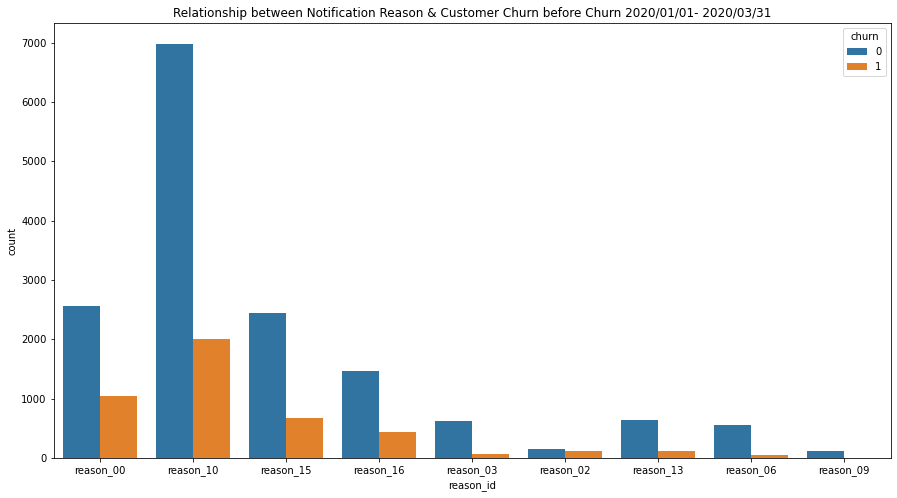

In [76]:
plt.figure(figsize=(15,8))
sns.countplot(x="reason_id", hue="churn", data=notifs_churn_users).\
           set_title('Relationship between Notification Reason & Customer Churn before Churn 2020/01/01- 2020/03/31');

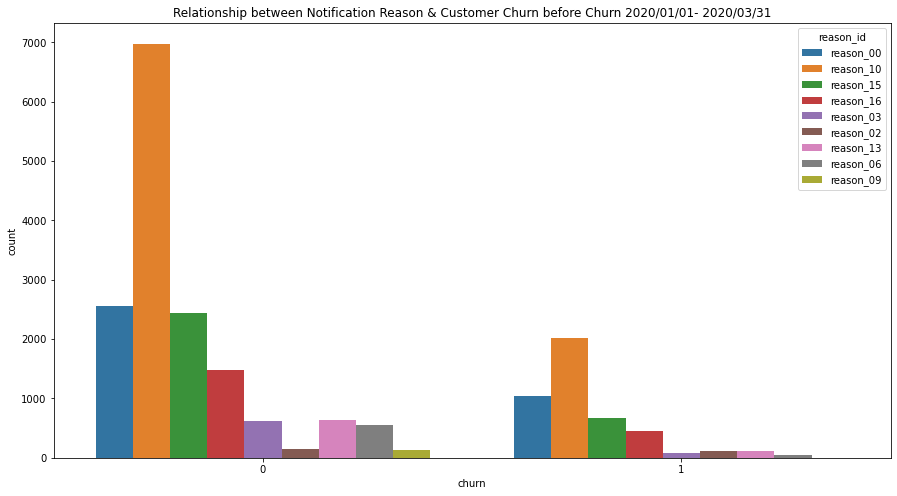

In [77]:
plt.figure(figsize=(15,8))
sns.countplot(x="churn", hue="reason_id", data=notifs_churn_users).\
           set_title('Relationship between Notification Reason & Customer Churn before Churn 2020/01/01- 2020/03/31');

In [78]:
notif_reason=pd.read_csv('../data/reason_type.csv')
notif_reason

,reason_id,reason_name
0,reason_00,REENGAGEMENT_ACTIVE_FUNDS
1,reason_01,PUMPKIN_PAYMENT_NOTIFICATION
2,reason_02,NO_INITIAL_CARD_USE
3,reason_03,ENGAGEMENT_SPLIT_BILL_RESTAURANT
4,reason_04,METAL_RESERVE_PLAN
5,reason_05,ONBOARDING_TIPS_ACTIVATED_USERS
6,reason_06,MADE_MONEY_REQUEST_NOT_SPLIT_BILL
7,reason_07,PREMIUM_ENGAGEMENT_INACTIVE_CARD
8,reason_08,NO_INITIAL_CARD_ORDER
9,reason_09,PREMIUM_ENGAGEMENT_FEES_SAVED


In [79]:
notif_table = pd.crosstab(notifs_churn_users.reason_id, notifs_churn_users.churn)
notif_table

churn,0,1
reason_id,,
reason_00,2564,1045
reason_02,147,111
reason_03,625,73
reason_06,556,54
reason_09,123,3
reason_10,6978,2011
reason_13,633,114
reason_15,2436,677
reason_16,1471,444


In [80]:
notif_table_pct = pd.crosstab(notifs_churn_users.reason_id, notifs_churn_users.churn, normalize='index')
notif_table_pct

churn,0,1
reason_id,,
reason_00,0.710446,0.289554
reason_02,0.569767,0.430233
reason_03,0.895415,0.104585
reason_06,0.911475,0.088525
reason_09,0.976190,0.023810
reason_10,0.776282,0.223718
reason_13,0.847390,0.152610
reason_15,0.782525,0.217475
reason_16,0.768146,0.231854


In [81]:
from scipy.stats import chi2_contingency
stat, p, dof, expected = chi2_contingency(notif_table, correction=False)
p

3.0252613640976836e-65

## - Why did customers churn? 
- Did churned users received have special state of transaction 2020/01/01- 2020/03/31?

In [92]:
trans_status

,record_date,user_id,cardholderpresence,trans_amount,trans_id,trans_state,trans_type_id
1,2020-03-19 06:15:59.537000+00:00,user_1652,FALSE,15.50,transaction_1,COMPLETED,type_1
2,2020-03-18 18:53:41.323000+00:00,user_1652,FALSE,43.40,transaction_2,COMPLETED,type_1
3,2020-03-22 14:20:01.513000+00:00,user_1652,NaN,10043.01,transaction_3,COMPLETED,type_0
4,2020-03-22 05:42:50.316000+00:00,user_5509,FALSE,43.81,transaction_4,COMPLETED,type_1
5,2020-03-25 04:08:49.772000+00:00,user_5509,FALSE,2.07,transaction_5,COMPLETED,type_1
...,...,...,...,...,...,...,...
1040699,2020-03-30 18:40:00.394000+00:00,user_3597,FALSE,7.99,transaction_1040699,COMPLETED,type_1
1040712,2020-03-30 23:38:08.295000+00:00,user_8447,FALSE,3.75,transaction_1040712,COMPLETED,type_1
1040734,2020-03-30 22:43:28.633000+00:00,user_5794,FALSE,5.30,transaction_1040734,COMPLETED,type_1
1040751,2020-03-30 20:26:25.983000+00:00,user_3233,FALSE,6.00,transaction_1040751,COMPLETED,type_1


In [82]:
trans_status=trans_df.loc[(trans_df.user_id.isin(trans_active_user.index))&(trans_df.record_date>day1)&((trans_df.record_date<=cut_day)),: ]
trans_status_users=pd.merge(trans_status,trans_user['churn'], how='inner', on='user_id')
trans_status_users

,record_date,user_id,cardholderpresence,trans_amount,trans_id,trans_state,trans_type_id,churn
0,2020-03-19 06:15:59.537000+00:00,user_1652,FALSE,15.50,transaction_1,COMPLETED,type_1,0
1,2020-03-18 18:53:41.323000+00:00,user_1652,FALSE,43.40,transaction_2,COMPLETED,type_1,0
2,2020-03-22 14:20:01.513000+00:00,user_1652,NaN,10043.01,transaction_3,COMPLETED,type_0,0
3,2020-03-17 17:57:06.816000+00:00,user_1652,FALSE,10.44,transaction_6,COMPLETED,type_1,0
4,2020-03-17 21:22:28.723000+00:00,user_1652,FALSE,20.83,transaction_7,COMPLETED,type_1,0
...,...,...,...,...,...,...,...,...
270943,2020-03-30 11:54:14.163000+00:00,user_3921,NaN,150.00,transaction_1040221,COMPLETED,type_4,0
270944,2020-03-30 13:49:01.056000+00:00,user_3921,FALSE,61.81,transaction_1040349,COMPLETED,type_3,0
270945,2020-03-30 13:33:43.235000+00:00,user_3921,FALSE,69.86,transaction_1040366,COMPLETED,type_1,0
270946,2020-03-30 11:53:50.709000+00:00,user_3921,NaN,1.00,transaction_1040589,REVERTED,type_4,0


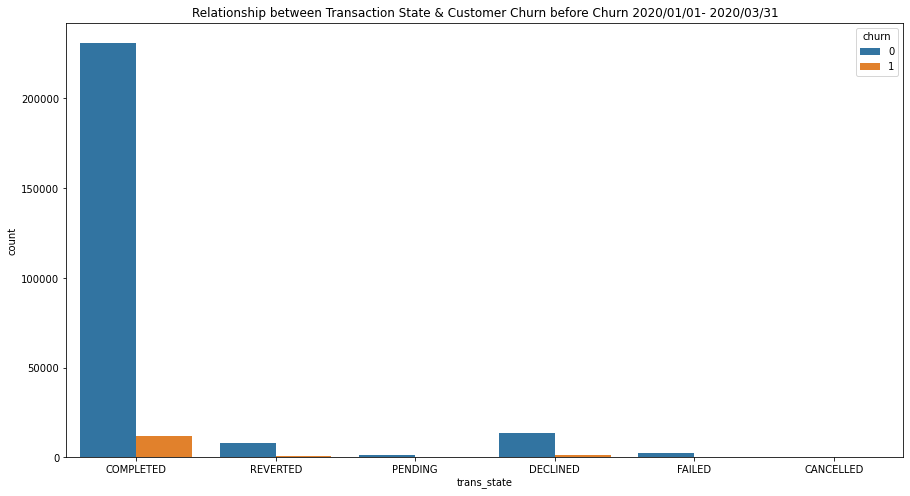

In [83]:
plt.figure(figsize=(15,8))
sns.countplot(x="trans_state", hue="churn", data=trans_status_users).\
           set_title('Relationship between Transaction State & Customer Churn before Churn 2020/01/01- 2020/03/31')
plt.yscale='log';

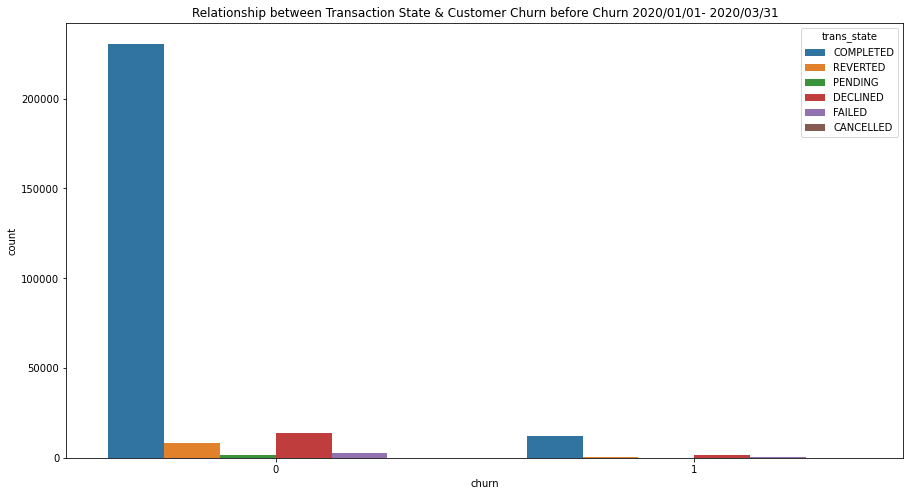

In [91]:
plt.figure(figsize=(15,8))
sns.countplot(x="churn", hue="trans_state", data=trans_status_users).\
           set_title('Relationship between Transaction State & Customer Churn before Churn 2020/01/01- 2020/03/31')
plt.yscale='log';

In [98]:
state_table = pd.crosstab(trans_status_users.trans_state, trans_status_users.churn)
state_table

churn,0,1
trans_state,,
CANCELLED,112,8
COMPLETED,230646,12125
DECLINED,13677,1334
FAILED,2651,266
PENDING,1346,55
REVERTED,8062,666


In [97]:
state_table_pct = pd.crosstab(trans_status_users.trans_state, trans_status_users.churn, normalize='columns')
state_table_pct

churn,0,1
trans_state,,
CANCELLED,0.000437,0.000553
COMPLETED,0.899226,0.838868
DECLINED,0.053323,0.092293
FAILED,0.010336,0.018403
PENDING,0.005248,0.003805
REVERTED,0.031432,0.046077


In [99]:
from scipy.stats import chi2_contingency
stat, p, dof, expected = chi2_contingency(state_table, correction=False)
p

1.10745960465461e-129

## - Have churned users received special notifications 2020/03/31- 2020/04/30?

In [ ]:
day2='2020-04-30'
notifs_churn_after=notifs_df.loc[(notifs_df.user_id.isin(trans_active_user.index))&\
                                 (notifs_df.record_date>cut_day)&(notifs_df.record_date<=day2),: ]
notifs_churn_users_after=pd.merge(notifs_churn_after,trans_user['churn'], how='inner', on='user_id')
plt.figure(figsize=(15,8))
sns.countplot(x="reason_id", hue="churn", data=notifs_churn_users_after).\
           set_title('Relationship between Notification Reason & Customer Churn after Churn 2020/03/31- 2020/04/30');

## - Assume you could find a solution that costs 10usd per user, but can re-engage 5% of  the churned customers. How do you estimate the impact of your model on a dataset including 50000 users with the current churn rate, assuming 1% decline in the churn rate will add an extra 10,000usd in revenue. Assume your model predict 11% of the new users will churn.

In [70]:
churn_rate_now=np.sum(y_test==1)*100/len(y_test)
n_users=50000
n_churned_user=n_users*churn_rate_now
base_model_cost=10*n_users
base_model_churned_user=.95*churn_rate_now
base_model_churn_rate=base_model_churned_user*100/n_users
base_model_rev=10000*(churn_rate_now-base_model_churn_rate)
churn_rate_now, base_model_cost, base_model_churned_user,base_model_churn_rate, base_model_rev, base_model_rev-base_model_cost

(23.205741626794257,
 500000,
 22.045454545454543,
 0.04409090909090909,
 231616.5071770335,
 -268383.49282296654)

In [72]:
np.sum(svc_pred==1)/len(y_test)

0.11004784688995216

In [74]:
svc_model_cost=10*(.11*n_users)
svc_model_churned_user=.11*n_users*precision_score(y_test, svc_pred)
svc_model_churn_rate=svc_model_churned_user*100/n_users
svc_model_rev=10000*(churn_rate_now-svc_model_churn_rate)
churn_rate_now, svc_model_cost, svc_model_churned_user,svc_model_churn_rate, svc_model_rev, svc_model_rev-svc_model_cost

(23.205741626794257,
 55000.0,
 3646.7391304347825,
 7.293478260869565,
 159122.6336592469,
 104122.6336592469)